## RISK MANAGEMENT
**GROUP WORK PROJECT:** 3


---


### Installing the libraries

In [1]:
!pip install -qq "git+https://github.com/lopatovsky/HMMs.git"

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.5 MB/s eta 0:00:00


In [2]:
!pip install -qq pgmpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 37.0 MB/s eta 0:00:00


In [3]:
#install the apis for FRED
!pip install -qq fredapi

In [4]:
#install the apis for EIA
!pip install -qq myeia

### Importing the modules

In [5]:
import numpy as np
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch, K2Score,BDeuScore,BicScore

import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import Colormap, ListedColormap, BoundaryNorm

In [6]:
import warnings
warnings.filterwarnings("ignore")

#### Fetching the datasets

In [70]:
# EIA API key
%env EIA_TOKEN=SQDqu9rDVZGiyuTKvLotm34t59vimFfcfXKTpNfe
#Specify the API key
fred_key = "87769799aa7b2dc41a0590ed8a688283"

#Import the necessary libraries
import datetime
from myeia.api import API
from fredapi import Fred
import matplotlib.pyplot as plt

#Define the data series ID from the EIA
datasets_eia = [
'STEO.PAPR_NONOPEC.M',
'STEO.PAPR_OPEC.M',
'STEO.PATC_OECD.M',
'STEO.PATC_NON_OECD.M',
'STEO.COPRPUS.M',
'STEO.CORIPUS.M',
'STEO.PASC_OECD_T3.M',
'STEO.COPS_OPEC.M',
'STEO.COPC_OPEC.M',
'STEO.T3_STCHANGE_OOECD.M',
'STEO.T3_STCHANGE_NOECD.M'
]
#Define the data series ID from the FRED
datasets_fred = [
    'FEDFUNDS',
    'CPIENGSL',
    'CUSR0000SEHE',
    'PCU211211',
    'PCU213111213111',
    'PCU213111213111P',
    'WPS601103',
    'PCU324191324191S',
    'PCU3241913241910',
    'PCU324110324110J',
    'CAPG211S',
    'CAPUTLG211S',
    'IPG211S',
    'IPG211111CN',
    'INDPRO',
    'IPN213111N',
    'IPMINE',
    'IR10000'
]

data_merge = []; # List of dataframes to be concatenated

# Adding EIA datasets

# Initiates a session with the EIA repo to recieve datasets
eia_api = API()

for series_id in datasets_eia:
  df = eia_api.get_series(series_id=series_id)
  print(f'Downloading EIA dataset with series_id: {series_id}')
  df.columns = [series_id];
  data_merge.append(df);

# Adding FRED datasets

# Initiates a session with the FRED API to receive datasets
fred = Fred(api_key=fred_key);

for series_id in datasets_fred:
  df = pd.DataFrame(fred.get_series(series_id), columns=[series_id]);
  print(f'Downloading FRED dataset with series_id: {series_id}')
  data_merge.append(df);

env: EIA_TOKEN=SQDqu9rDVZGiyuTKvLotm34t59vimFfcfXKTpNfe


In [101]:
data_fred_eia = data_merge.copy()

datasets_macro = datasets_eia + datasets_fred + ['WTISPLC', 'forecast'];

current =  pd.DataFrame(fred.get_series('WTISPLC'), columns=['WTISPLC']);
forecast = pd.DataFrame(fred.get_series('WTISPLC').shift(-1),
                        columns=['forecast']);

data_fred_eia.append(current);
data_fred_eia.append(forecast);

df_macro = pd.concat(data_fred_eia, axis=1, join='inner');
df.dropna(axis=1, inplace=True)

In [102]:
train_data = df_macro[:180]
val_data = df_macro[180:200]
test_data = df_macro[200:]

#### Discretization

In [103]:
import hmms

trained_hmms = {}

for series_id in df_macro:
  print(series_id)
  if series_id == 'forecast':
    break;
  else:
    dhmm = hmms.DtHMM.random(3, 2)
    data_diff = train_data[series_id].diff()[1:]
    emit_seq = np.array_split(data_diff.apply(
                lambda x: 1 if x > 0 else 0).values, 32)
    dhmm.baum_welch(emit_seq, 100)
    trained_hmms[series_id]=dhmm

# Create DataFrame for training data
disc_train = pd.DataFrame(index=train_data[1:].index)

# Step 2: Using the trained models for Viterbi
for i, series_id in enumerate(df_macro):
  if series_id == 'forecast':
    dhmm = trained_hmms['WTISPLC']
  else:
    dhmm = trained_hmms[series_id]
  data_diff = train_data[series_id].diff()[1:]
  emit_seq = np.array(data_diff.apply(
              lambda x: 1 if x > 0 else 0).values)
  log_prob, s_seq = dhmm.viterbi(emit_seq)
  disc_train[series_id] = s_seq

STEO.PAPR_NONOPEC.M
iteration  1 / 100
iteration  2 / 100
iteration  3 / 100
iteration  4 / 100
iteration  5 / 100
iteration  6 / 100
iteration  7 / 100
iteration  8 / 100
iteration  9 / 100
iteration  10 / 100
iteration  11 / 100
iteration  12 / 100
iteration  13 / 100
iteration  14 / 100
iteration  15 / 100
iteration  16 / 100
iteration  17 / 100
iteration  18 / 100
iteration  19 / 100
iteration  20 / 100
iteration  21 / 100
iteration  22 / 100
iteration  23 / 100
iteration  24 / 100
iteration  25 / 100
iteration  26 / 100
iteration  27 / 100
iteration  28 / 100
iteration  29 / 100
iteration  30 / 100
iteration  31 / 100
iteration  32 / 100
iteration  33 / 100
iteration  34 / 100
iteration  35 / 100
iteration  36 / 100
iteration  37 / 100
iteration  38 / 100
iteration  39 / 100
iteration  40 / 100
iteration  41 / 100
iteration  42 / 100
iteration  43 / 100
iteration  44 / 100
iteration  45 / 100
iteration  46 / 100
iteration  47 / 100
iteration  48 / 100
iteration  49 / 100
iteration

In [104]:
disc_vald = pd.DataFrame(index = val_data[1:].index);
for i, series_id in enumerate(df_macro):
  if series_id == 'forecast':
    dhmm = trained_hmms['WTISPLC']
  else:
    dhmm = trained_hmms[series_id]
  data_diff =  val_data[series_id].diff()[1:];
  emit_seq = np.array(data_diff.apply(lambda x: 1 if x > 0 else 0).values);
  ( log_prob, s_seq ) =  dhmm.viterbi(emit_seq);
  disc_vald[series_id] = s_seq;

In [105]:
disc_test = pd.DataFrame(index = test_data[1:].index);
for i, series_id in enumerate(df_macro):
  if series_id == 'forecast':
    dhmm = trained_hmms['WTISPLC']
  else:
    dhmm = trained_hmms[series_id]
  data_diff =  test_data[series_id].diff()[1:];
  emit_seq = np.array(data_diff.apply(lambda x: 1 if x > 0 else 0).values);
  ( log_prob, s_seq ) =  dhmm.viterbi(emit_seq);
  disc_test[series_id] = s_seq;

#### Model Training

In [106]:
def train_model(train_data, max_iter=10, scoring_method=K2Score):

    # Run Hill Climb Search
    hc = HillClimbSearch(train_data)
    scorer = scoring_method(train_data)
    best_model = hc.estimate(scorer, max_iter=max_iter)

    # Print the edges of the best model
    print("Edges of the best model:", best_model.edges())

    # Create an instance of BayesianNetwork
    model = BayesianNetwork(best_model.edges())

    # Fit the model to your data (learn the parameters)
    model.fit(train_data)

    return model

In [107]:
import networkx as nx
import pylab as plt

def validate_model(model, validation_data):
    list_cols = list(model.nodes)
    list_cols.remove('forecast')

    val_data = validation_data.copy()
    y_val = val_data['WTISPLC'].tolist()
    val_data.drop('forecast', axis=1, inplace=True)

    y_val_pred = model.predict(val_data[list_cols])

    print("\nPredicted Value: ")
    print(y_val_pred['forecast'].to_list())
    print("\nReal Value: ")
    print(y_val)

    error = np.mean(y_val != np.roll(y_val_pred, 1))
    print("\nError: ")
    print(round(error * 100, 2))

def test_model(model, testing_data):
    list_cols = list(model.nodes)
    list_cols.remove('forecast')

    test_data = testing_data.copy()
    y_test = test_data['WTISPLC'].tolist()
    test_data.drop('forecast', axis=1, inplace=True)

    y_test_pred = model.predict(test_data[list_cols])
    print("\nPredicted Value: ");
    print(y_test_pred['forecast'].to_list());
    print("\nReal Value: ");
    print(y_test);

    error = np.mean(y_test !=  np.roll(y_test_pred, 1));
    print("\nError: ");
    print(round(error* 100,2));
    return y_test_pred

def plot_network_graph(model):
    G = nx.Graph()
    G.add_edges_from(model.edges())
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=10)
    nx.draw_networkx_edges(G, pos, arrows=True)
    plt.figure(5, figsize=(20, 10))
    plt.show()

In [108]:
model1 = train_model(train_data=disc_train, max_iter=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Edges of the best model: [('PCU213111213111', 'PCU213111213111P'), ('WPS601103', 'STEO.PASC_OECD_T3.M'), ('IPG211S', 'WPS601103'), ('IPG211111CN', 'STEO.COPRPUS.M'), ('forecast', 'WTISPLC')]


### Model Validation Iteration #1

In [109]:
###Doing the prediction on validation dataset
validate_model(model1, disc_vald)

  0%|          | 0/10 [00:00<?, ?it/s]


Predicted Value: 
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 2, 2, 1]

Real Value: 
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 2, 2, 0]

Error: 
59.0


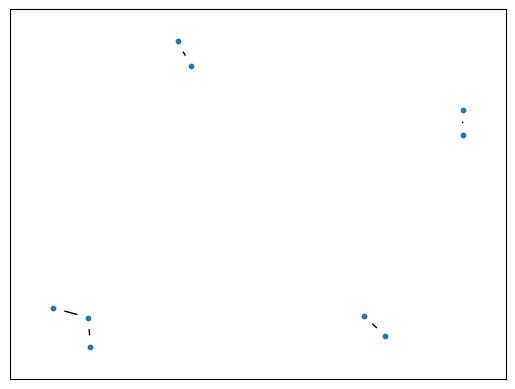

<Figure size 2000x1000 with 0 Axes>

In [110]:
plot_network_graph(model1)

Based on the model validation results, below are the observations:

Error Rate: The error rate of 59.0% suggests that the model's predictions are not very accurate, and indicates room for improvement.

Disconnected Trees: The presence of 4 disconnected trees indicates that the Bayesian network structure might not be optimal. Ideally, we want a more connected graph to improve forecasting accuracy.

Thus, we will reevaluate the model, and/or re-run the hill climibing algorithm to potentially find a better network structure, and aim for more connected graph, and reasses the performance of the model using the validation set.This can be done iteratively to refine the model untill we obtain the satisfactory results.

### Re-running the Hill Climbing Algorithm with different scoring method (BDeuScore) and finding the performance on Validation data

In [111]:
model2 = train_model(train_data=disc_train, max_iter=10,scoring_method=BDeuScore)

  0%|          | 0/10 [00:00<?, ?it/s]

Edges of the best model: [('STEO.COPRPUS.M', 'IPG211111CN'), ('CPIENGSL', 'WTISPLC'), ('CPIENGSL', 'PCU211211'), ('CUSR0000SEHE', 'CPIENGSL'), ('PCU213111213111', 'PCU213111213111P'), ('PCU213111213111P', 'WPS601103'), ('WPS601103', 'STEO.PASC_OECD_T3.M'), ('WPS601103', 'IPG211S'), ('CAPG211S', 'STEO.CORIPUS.M'), ('forecast', 'WTISPLC')]


### Model Validation Iteration #2

In [112]:
validate_model(model2, disc_vald)

  0%|          | 0/18 [00:00<?, ?it/s]


Predicted Value: 
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 2, 2, 1]

Real Value: 
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 2, 2, 0]

Error: 
59.0


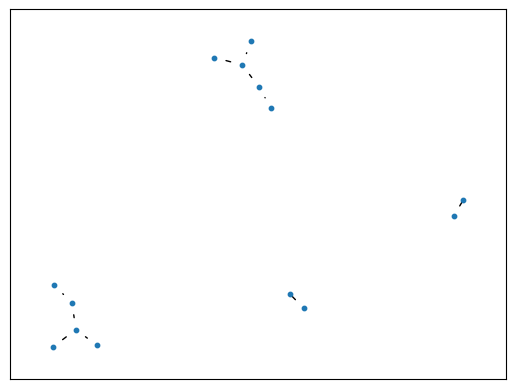

<Figure size 2000x1000 with 0 Axes>

In [113]:
plot_network_graph(model2)

With different scoring method, the error rate remained the same to 59.0%, and also the number of disconnected network components remained the same to 4. We'll further fine-tune it with increasing the number of iterations by adjusting the `max_iter` parameter.

### Re-running the Hill Climbing Algorithm with changing the number of iterations

In [114]:
model3 = train_model(train_data=disc_train, max_iter=60)

  0%|          | 0/60 [00:00<?, ?it/s]

Edges of the best model: [('STEO.PATC_OECD.M', 'STEO.T3_STCHANGE_OOECD.M'), ('STEO.PATC_OECD.M', 'STEO.COPC_OPEC.M'), ('STEO.COPRPUS.M', 'CAPUTLG211S'), ('STEO.COPRPUS.M', 'IPMINE'), ('STEO.CORIPUS.M', 'CAPG211S'), ('STEO.CORIPUS.M', 'PCU213111213111'), ('STEO.CORIPUS.M', 'PCU324110324110J'), ('STEO.CORIPUS.M', 'STEO.PAPR_OPEC.M'), ('STEO.PASC_OECD_T3.M', 'STEO.PATC_OECD.M'), ('STEO.PASC_OECD_T3.M', 'STEO.PATC_NON_OECD.M'), ('STEO.COPS_OPEC.M', 'STEO.PAPR_OPEC.M'), ('STEO.COPC_OPEC.M', 'STEO.PAPR_OPEC.M'), ('STEO.T3_STCHANGE_OOECD.M', 'STEO.PATC_NON_OECD.M'), ('STEO.T3_STCHANGE_NOECD.M', 'STEO.PATC_NON_OECD.M'), ('STEO.T3_STCHANGE_NOECD.M', 'STEO.PATC_OECD.M'), ('STEO.T3_STCHANGE_NOECD.M', 'STEO.PAPR_NONOPEC.M'), ('CPIENGSL', 'CUSR0000SEHE'), ('CPIENGSL', 'PCU211211'), ('CPIENGSL', 'STEO.PAPR_NONOPEC.M'), ('CUSR0000SEHE', 'STEO.PASC_OECD_T3.M'), ('CUSR0000SEHE', 'INDPRO'), ('PCU211211', 'CUSR0000SEHE'), ('PCU211211', 'STEO.PAPR_NONOPEC.M'), ('PCU211211', 'STEO.COPC_OPEC.M'), ('PCU21311

### Model Validation Iteration #3

In [115]:
validate_model(model3, disc_vald)

  0%|          | 0/19 [00:00<?, ?it/s]


Predicted Value: 
[0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 2, 1, 1, 0, 0, 1]

Real Value: 
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 2, 2, 0]

Error: 
57.34


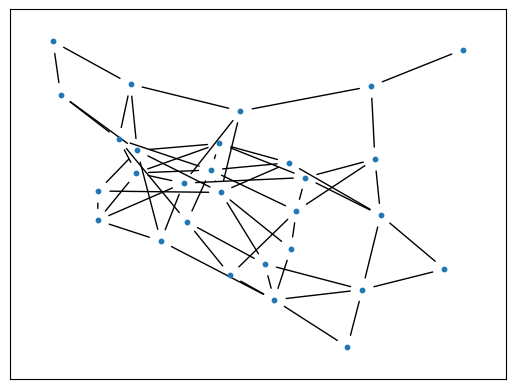

<Figure size 2000x1000 with 0 Axes>

In [116]:
plot_network_graph(model3)

With increase in the number of iterations, the error rate reduced to 57.34% though not sizeably, and there is only 1 disconnected network component thus improved alot. There can be more iterations, but now we'll use the prediction with the test data.

### Testing/Prediction

In [122]:
y_test_pred = test_model(model3, disc_test)

  0%|          | 0/18 [00:00<?, ?it/s]


Predicted Value: 
[1, 0, 1, 1, 0, 0, 1, 2, 1, 2, 1, 0, 1, 0, 1, 0, 0, 2]

Real Value: 
[1, 0, 1, 0, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 2, 2, 2]

Error: 
63.89


#### Interpretation of Results

In [118]:
test_price = pd.DataFrame(test_data['WTISPLC'], columns=['WTISPLC']);
test_signal = pd.DataFrame(y_test_pred, columns=['forecast']);
test_sheet = pd.concat([test_price.reset_index(drop=True), test_signal], axis=1)
test_sheet.index = test_price.index

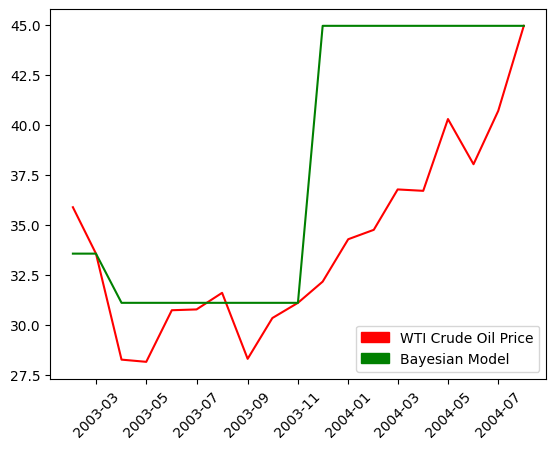

In [119]:
trades = [test_sheet['WTISPLC'].iloc[0]];

position = False; # True for Long, False for Short

for i in range(len(test_sheet)-1):
    if test_sheet['forecast'].iloc[i+1] == 0:
        trades.append(trades[-1]);
    elif test_sheet['forecast'].iloc[i+1] == 2:
        if position == False:
            position = True;
            trades.append(trades[-1]);
        else:
            trades.append(test_sheet['WTISPLC'].iloc[i+1]);
    else:
        trades.append(trades[-1]);

test_performance = pd.DataFrame(trades, index = test_sheet.index,
                                            columns=['performance']);
test_sheet = pd.concat([test_sheet, test_performance], axis=1, join='inner');


plt.plot(test_sheet['WTISPLC'], 'r');
plt.plot(test_sheet['performance'], 'g');
plt.xticks(rotation=45)

r_patch = mpatches.Patch(color='red', label='WTI Crude Oil Price');
g_patch = mpatches.Patch(color='green', label='Bayesian Model');
plt.legend(handles=[r_patch, g_patch], loc = 'lower right');